At the end of the experiment:

1. Perform dimensionality reduction using Autoencoder
2. Understand the relationship between Autoencoder and PCA


Let us start by importing all the required packages to perform this experiment:

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision.datasets as dsets
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Defining the Parameters

In [ ]:
EPOCH = 10
batch_size = 64
LR = 0.005      
DOWNLOAD_MNIST = False
### Number of images we want to test on
N_TEST_IMG = 10

### Loading MNIST Dataset from Torchvision Datasets

In [ ]:
#Loading the train set file
train_data = dsets.MNIST(root='../data', 
                            train=True, 
                            transform=transforms.ToTensor(),  
                            download=True)
#Loading the test set file
test_data = dsets.MNIST(root='../data', 
                           train=False, 
                           transform=transforms.ToTensor())

### Visulaizing one of the Training Data

torch.Size([60000, 28, 28])
torch.Size([60000])


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


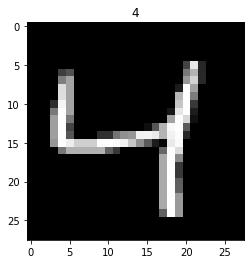

In [ ]:
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[2])
plt.show()

In [ ]:
#loading the train dataset
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True)

# loading the test dataset

test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=batch_size, 
                                          shuffle=True)

### Building the Model

Here we are constructing an autoencoder model where the encoding network component is made up of four layers with 128, 64,12, 3 nodes. We we are trying to compress the data into 3 features which can be easily visualized. Decoding network component is made up of four layers with 3, 12, 64, 128 nodes. Each layer output in encoding and decoding network are passed through Tanh activation function.



In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            # activation functions
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            #activation functionsisualize the kernels and output of each filter at given layer

#Understanding deep image representation

#Visualize learned representations of layes
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

To get the feel of how an autoencoder works, let us first try to plot the original and decoded image at every iteration. In the initial stage of iteration the decoded images contains more noise. As the iteration increases the noise get decreased and we will be able to see that the decoded images are similar to the original images.


In [ ]:
k = []
for i in range(10):
  k.append(i)

In [ ]:
k

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Epoch:  0 | train loss: 0.2329


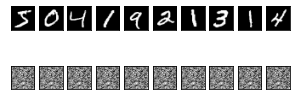

Epoch:  0 | train loss: 0.0593


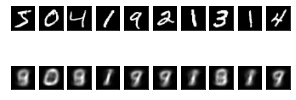

Epoch:  5 | train loss: 0.0396


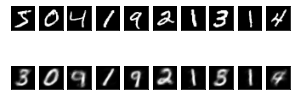

Epoch:  5 | train loss: 0.0341


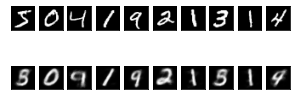

Epoch:  9 | train loss: 0.0387


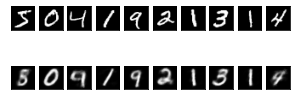

Epoch:  9 | train loss: 0.0335


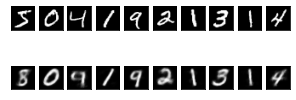

In [ ]:
autoencoder = AutoEncoder()
print(autoencoder)

# Initialization of Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
## Initialization of Mean Square Error
loss_func = nn.MSELoss()
all_train_data = np.empty((0,784))
# original data (first row) for viewing
view_data = train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):



        b_x = x.view(-1, 28*28)   # batch x, shape (batch, 28*28)
        b_y = x.view(-1, 28*28)   # batch y, shape (batch, 28*28)
        b_label = y               # batch label. We don't however use this label here since the label is the image itself i.e. b_y
        if  epoch == 0: #This is used later for PCA fit
          all_train_data = np.concatenate([all_train_data,b_x])

        encoded, decoded = autoencoder(b_x)
        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 500 == 0 and epoch in [0, 5, EPOCH-1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item())
            # plotting decoded image (second row)
            encoded_data, decoded_data = autoencoder(view_data)
            # initialize figure
            f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
            #Plotting orginal images
            for i in range(N_TEST_IMG):
                a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())
            # Plotting the decoded images
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.show(); 

Applying Autoencoders on the test data and finding the loss on the test dataset

In [ ]:
# Initialization of Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
## Initialization of Mean Square Error
loss_func = nn.MSELoss()

# original data (first row) for viewing
view_data = test_data.test_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.
all_test_data = np.empty((0,784))
loss = 0

for step, (x, y) in enumerate(test_loader):
    b_x = x.view(-1, 28*28)   # batch x, shape (batch, 28*28)
    b_y = x.view(-1, 28*28)   # batch y, shape (batch, 28*28)
    b_label = y               # batch label.We don't however use this label here since the label is the image itself i.e. b_y
    all_test_data = np.concatenate([all_test_data,b_x])

    encoded, decoded = autoencoder(b_x)
    loss += loss_func(decoded, b_y)

print(loss)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


tensor(5.7722, grad_fn=<AddBackward0>)


In [ ]:
all_train_data.shape, all_test_data.shape

((60000, 784), (10000, 784))

In [ ]:
all_data = np.concatenate([all_train_data,all_test_data])

In [ ]:
all_data.shape

(70000, 784)

Applying PCA on the data:

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
# Reconstruct original data
# Perform PCA for three components
pca = PCA(3)
pca.fit(all_train_data)
loss = 0
for step, (x, y) in enumerate(test_loader):
        b_x = (x.view(-1, 28*28))   # batch x, shape (batch, 28*28)
        b_y = (x.view(-1, 28*28))
        b_x = np.array(b_x)
        b_y = np.array(b_y)
        #data_reduced = pca.fit_transform(b_x)
        data_reduced = pca.transform(b_x)
        data_reconstructed = pca.inverse_transform(data_reduced)
        loss += ((abs(data_reconstructed) - (b_x)) ** 2).mean()
print(loss)

8.09331632424655
